# Deep Learning Trader
James Chan 2018

## Overview
The recent advancement in deep learning has open new possibilities for those involved in the business of forecasting. Deep learning is basically a neural network with a many hidden layers.  The more layers it has, the more complexity the model is, which allows the learning of highly non-linear, high dimensional functions.  This exercise focus on applying fully connected network to the domain of stock trading.  

<img src="img/nn.png"/>
<center><b>Figure 1. Neural Network</b></center> 

### Table of Content
1. Framing the Problem
2. Create the Model
3. Fit the Model
4. Back Test
5. Conclusion

In [2]:
import pandas as pd
from trader_utils import BackTester, predictions_to_trades, get_xy
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import StandardScaler
%matplotlib inline

Using TensorFlow backend.


## 1. Framing the Problem
N-day labeling is a typical technique in which we map the return after N day to the technical indicator values of a given day. As shown below, when the return is positive, we go ahead and give the indicators on that day a label of 1.  If it is negative, we are going to assign the indicator values with a 0.  This is how we format our samples for the learner.  We hope that our learner will learn to recongize the combinations of indicator values that associates with certain price movement.


<img src="img/framing.png"/>
<center><b>Figure 2. Fully Connected Network Samples Formulation</b></center> 

## 2. Create the Model
Most of the heavy lifting has been encapsulated into traders_util.py, which includes methods for generating the indicator values, for back testing, and for plotting.  Here we build on top of it deep learning using Keras.  The following parameters have been identified as desirable for in-sample performance:
1. Indicators of P/SMA Ratio, Bollinger Bands, and Volatility with a rolling window of 21.
2. N-day return where N = 1
3. Fully connected network with an input layer of 64 nodes and 4 hidden layers of 64 nodes.
4. Activation function of relu for all hidden and input layers. Sigmoid for output layer.
5. Binary cross-entropy as the loss function and Adam for backprop
6. 500 epochs with full batches.

The input data are also standardized using StandardScaler from sci-kit Learn.  Training is about a whole magnitude faster for this problem when the data are standardized.

In [3]:
class DeepLearningTrader:
    def __init__(self):
        self.n = 1
        self.rolling_window = 21
        self.ticker = None
        self.scaler = None

    def fit(self, ticker, start_date, end_date): 
        self.ticker = ticker
        
        #get indicator values
        train_x, train_y = get_xy(ticker, start_date, end_date, self.rolling_window, self.n)
        
        #transform X with standard scaler
        scaler = StandardScaler()
        scaler.fit(train_x)
        self.scaler = scaler
        train_x = scaler.transform(train_x)
        
        #create deep learning model
        model = Sequential()
        model.add(Dense(64, input_dim=3, activation='relu'))
        for i in range(4):
            model.add(Dense(64, activation='relu'))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
        
        #train the model
        model.fit(train_x, train_y, epochs=500, verbose=0)
        
        #store the model
        self.model = model
    
    def generate_trades(self, start_date, end_date):
        test_x, _ = get_xy(self.ticker, start_date, end_date, self.rolling_window, self.n)
        test_x = self.scaler.transform(test_x)
        predictions = self.model.predict_classes(test_x)
        actual_start = self.rolling_window - 1
        trades = predictions_to_trades(self.ticker, predictions, start_date, end_date, self.n, actual_start)
        return trades

## 3. Fit the Model
Here we intialize the learner and define some test cases for it

In [4]:
#initialize
dlt = DeepLearningTrader()

In [5]:
#define test cases

#test 1 case GOOG
in_sd = pd.datetime(2011,1,1)
in_ed = pd.datetime(2011,12,31)
out_sd = pd.datetime(2012,1,1)
out_ed = pd.datetime(2012,12,31)
ticker = 'GOOG'

# #test 2 case JPM
# in_sd = pd.datetime(2008,1,1)
# in_ed = pd.datetime(2009,12,31)
# out_sd = pd.datetime(2010,1,1)
# out_ed = pd.datetime(2011,12,31)
# ticker = 'JPM'

# #test 3 case AMZN
# in_sd = pd.datetime(2008,1,1)
# in_ed = pd.datetime(2009,12,31)
# out_sd = pd.datetime(2010,1,1)
# out_ed = pd.datetime(2011,12,31)
# ticker = 'AMZN'

# #test 4 case AAPL
# in_sd = pd.datetime(2008,1,1)
# in_ed = pd.datetime(2009,12,31)
# out_sd = pd.datetime(2010,1,1)
# out_ed = pd.datetime(2011,12,31)
# ticker = 'AAPL'


In [6]:
#train model
dlt.fit(ticker, in_sd, in_ed)    

## 4. Back Test
Let's see how our Deep Learning Trader perform.

In [7]:
#intialize backtester
starting_cash = 100000
holding_limit = 1000
btr = BackTester(starting_cash, holding_limit)

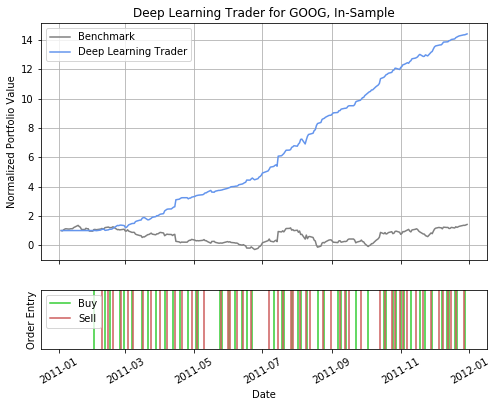

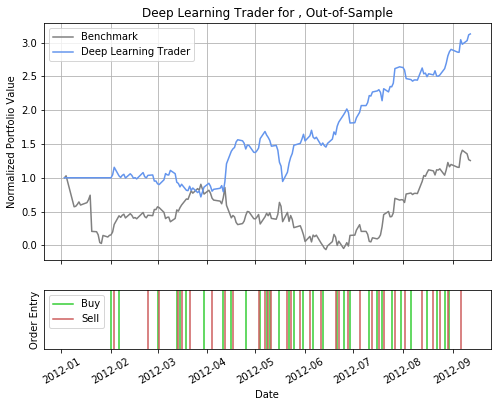

In [8]:
#generate trade in-sample
df_trades = dlt.generate_trades(in_sd, in_ed) 

plot_title = 'Deep Learning Trader for {}, In-Sample'.format(ticker)
algorithm_title = 'Deep Learning Trader'
btr.backtest(df_trades, plot_title, algorithm_title, benchmark=True, plot_size=(8,6))

#out-of-sample
start_date = pd.datetime(2012,1,1)
end_date = pd.datetime(2012,12,31)

#generate trade out-of-sample
df_trades = dlt.generate_trades(out_sd, out_ed) 
plot_title = 'Deep Learning Trader for , Out-of-Sample'.format(ticker)
algorithm_title = 'Deep Learning Trader'
btr.backtest(df_trades, plot_title, algorithm_title, benchmark=True, plot_size=(8,6)) 

## Conclusion
The In-sample result is phenonmenal.  It pretty much fitted the entire the data set.  This is something that is typically not as easily achieved as some of the models with lower variance.  The out-of-sample performance is also phenonmenal.  

As always, more testing for out-of-sample will need to be conducted before we can conclude on the validity of a truly profitable model. 